In [1]:
# import matplotlib.pyplot as plt
# from flow_analysis import Participant_Flow, Flow_Results

In [1]:
import os
import snirf
import datetime
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from scipy.signal import firwin, lfilter
from typing import Union
from statistics import mean
from behav_analysis import Participant_Behav
from data_functions import Data_Functions, load_results


class Process_Flow:
    """
    This class contains functions for processing Kernel Flow data.
    Wrapper around an snirf.Snirf object.
    """

    def __init__(self, filepath: str) -> None:
        """
        Initialize by loading SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.
        """
        self.data_fun = Data_Functions()
        self.snirf_file = self.load_snirf(filepath)

        self.missing_detector_pos_2d = [
            [0.2700519522879849, 0.92534462173171],
            [0.2100404073350992, 0.9599923033647436],
            [0.1500288623822143, 0.92534462173171],
            [0.1500288623822143, 0.856049258465643],
            [0.2100404073350992, 0.8214015768326095],
            [0.2700519522879849, 0.856049258465643],
        ]
        self.missing_source_pos_2d = [0.2100404073350983, 0.8906969400986755]
        self.missing_detector_pos_3d = [
            [34.18373257128052, 83.84749436111261, -3.421772079425661],
            [24.89193921324638, 87.59280827807989, -3.877662542873584],
            [19.49960518952535, 88.52633022589306, 4.53462776618961],
            [23.69484819349888, 86.5963118571706, 13.38774165295894],
            [32.93421777049451, 82.87888296072012, 13.83928277924401],
            [37.86338484008788, 80.87503761567585, 5.394829563438814],
        ]
        self.missing_source_pos_3d = [
            28.65886271209007,
            84.52123706248807,
            4.746746612880643,
        ]
        self.missing_measurement_list_data = {
            "measurement_list_index": [float("NaN")] * 12,
            "data_type": [99999] * 12,
            "data_type_index": ["HbO", "HbR"] * 6,
            "detector_index": [
                307,
                307,
                308,
                308,
                309,
                309,
                310,
                310,
                311,
                311,
                312,
                312,
            ],
            "source_index": [0] * 12,
        }

    def load_snirf(self, filepath: str) -> snirf.Snirf:
        """
        Load SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.

        Returns:
            snirf.Snirf: SNIRF file object.
        """
        return snirf.Snirf(filepath, "r+", dynamic_loading=True)

    def get_time_origin(
        self, fmt: str = "datetime", offset=True
    ) -> Union[datetime.datetime, float]:
        """
        Get the time origin (start time) from the SNIRF file.

        Args:
            fmt (str, optional): Format to get the time origin in: "datetime" or "timestamp". Defaults to "datetime".
            offset (bool): Offset the datetime by 4 hours. Defaults to True.

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            Union[datetime.datetime, float]:
                datetime.datetime: Time origin datetime.
                -or-
                float: Time origin timestamp.
        """
        start_date = self.snirf_file.nirs[0].metaDataTags.MeasurementDate
        start_time = self.snirf_file.nirs[0].metaDataTags.MeasurementTime
        start_str = start_date + " " + start_time
        if offset:
            time_origin = datetime.datetime.strptime(
                start_str, "%Y-%m-%d %H:%M:%S"
            ) - datetime.timedelta(
                hours=4
            )  # 4 hour offset
        else:
            time_origin = datetime.datetime.strptime(start_str, "%Y-%m-%d %H:%M:%S")
        if fmt.lower() == "datetime":
            return time_origin
        elif fmt.lower() == "timestamp":
            return datetime.datetime.timestamp(time_origin)
        else:
            raise Exception(
                "Invalid 'fmt' argument. Must be 'datetime' or 'timestamp'."
            )

    def get_subject_ID(self) -> str:
        """
        Get the subject ID from the SNIRF file.

        Returns:
            str: Subject ID.
        """
        return self.snirf_file.nirs[0].metaDataTags.SubjectID

    def get_time_rel(self) -> np.ndarray:
        """
        Get the relative time array from the SNIRF file.

        Returns:
            np.ndarray: Relative time array.
        """
        return self.snirf_file.nirs[0].data[0].time

    def get_time_abs(self, fmt: str = "datetime") -> np.ndarray:
        """
        Convert relative time array into an absolute time array.

        Args:
            fmt (str, optional): Format to get the time array in: "datetime" or "timestamp". Defaults to "datetime".

        Returns:
            np.ndarray: Absolute time array.
        """
        time_rel = self.get_time_rel()
        if fmt.lower() == "datetime":
            time_origin_dt = self.get_time_origin("datetime")
            return np.array(
                [
                    datetime.timedelta(seconds=time_rel[i]) + time_origin_dt
                    for i in range(len(time_rel))
                ]
            )
        elif fmt.lower() == "timestamp":
            time_origin_ts = self.get_time_origin("timestamp")
            return time_rel + time_origin_ts

    def get_data(
        self, fmt: str = "array", cols: list[int | list | tuple] = None
    ) -> Union[np.ndarray, pd.DataFrame]:
        """
        Get timeseries data from the SNIRF file.

        Args:
            fmt (str): Format of data (np.ndarray or pd.DataFrame). Defaults to "array".
            cols (list[int | list | tuple]): Data cols to select. Single col, list of cols, or slice of cols.
                                             Defaults to None (all columns).

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            np.ndarray: Timeseries data array.
        """
        if cols or cols == 0:
            if isinstance(cols, tuple):
                data = (
                    self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols[0] : cols[1]]
                )
            else:
                data = self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols]
        else:
            data = self.snirf_file.nirs[0].data[0].dataTimeSeries

        if "array" in fmt.lower():
            return data
        elif "dataframe" in fmt.lower():
            return pd.DataFrame(data)
        else:
            raise Exception("Invalid fmt argument. Must be 'array' or 'dataframe'.")

    def get_source_pos(self, dim: str, add_missing: bool = False) -> np.ndarray:
        """
        Get the 2D or 3D source position array.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            add_missing (bool): Add missing source data. Defaults to False.

        Returns:
            np.ndarray: 2D or 3D source position array.
        """
        if dim.lower() == "2d":
            source_pos_array_og = self.snirf_file.nirs[0].probe.sourcePos2D
            if add_missing:
                source_pos_array = np.vstack(
                    [np.array(self.missing_source_pos_2d), source_pos_array_og]
                )
                return source_pos_array
            else:
                return source_pos_array_og
        elif dim.lower() == "3d":
            source_pos_array_og = self.snirf_file.nirs[0].probe.sourcePos3D
            if add_missing:
                source_pos_array = np.vstack(
                    [np.array(self.missing_source_pos_3d), source_pos_array_og]
                )
                return source_pos_array
            else:
                return source_pos_array_og

    def get_detector_pos(self, dim: str, add_missing: bool = False) -> np.ndarray:
        """
        Get the 2D or 3D detector position array.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            add_missing (bool): Add missing detector data. Defaults to False.

        Returns:
            np.ndarray: 2D or 3D detector position array.
        """
        if dim.lower() == "2d":
            detector_pos_array_og = self.snirf_file.nirs[0].probe.detectorPos2D
            if add_missing:
                detector_pos_array = np.vstack(
                    [np.array(self.missing_detector_pos_2d), detector_pos_array_og]
                )
                return detector_pos_array
            else:
                return detector_pos_array_og
        elif dim.lower() == "3d":
            detector_pos_array_og = self.snirf_file.nirs[0].probe.detectorPos3D
            if add_missing:
                detector_pos_array_og = self.snirf_file.nirs[0].probe.detectorPos3D
                detector_pos_array = np.vstack(
                    [np.array(self.missing_detector_pos_3d), detector_pos_array_og]
                )
                return detector_pos_array
            else:
                return detector_pos_array_og

    def get_measurement_list(self) -> np.array:
        """
        Get the data measurement list.

        Returns:
            np.array: Data measurement list array.
        """
        return self.snirf_file.nirs[0].data[0].measurementList

    def get_source_labels(self, add_missing: bool = False) -> np.array:
        """
        Get the source labels.

        Args:
            add_missing (bool): Add missing source label. Defaults to False.

        Returns:
            np.array: Source label array.
        """
        source_labels_og = self.snirf_file.nirs[0].probe.sourceLabels
        if add_missing:
            missing_source_label = "S00"
            source_labels = np.insert(source_labels_og, 0, missing_source_label)
            return source_labels
        else:
            return source_labels_og

    def get_detector_labels(self, add_missing: bool = False) -> np.array:
        """
        Get the detector labels.

        Args:
            add_missing (bool): Add missing detector labels. Defaults to False.

        Returns:
            np.array: Detector label array.
        """
        detector_labels_og = self.snirf_file.nirs[0].probe.detectorLabels
        if add_missing:
            missing_detector_labels = [
                "D00d0",
                "D00d1",
                "D00d2",
                "D00d3",
                "D00d4",
                "D00d5",
            ]
            detector_labels = np.insert(detector_labels_og, 0, missing_detector_labels)
            return detector_labels
        else:
            return detector_labels_og

    def get_marker_df(self) -> pd.DataFrame:
        """
        Get a DataFrame of marker data from the "stim" part of the SNIRF file.

        Returns:
            pd.DataFrame: Marker "stim" data.
        """
        marker_data = self.snirf_file.nirs[0].stim[0].data
        marker_data_cols = self.snirf_file.nirs[0].stim[0].dataLabels
        return pd.DataFrame(marker_data, columns=marker_data_cols)

    def get_unique_data_types(self) -> list:
        """
        Get unique data types from the SNIRF file.

        Returns:
            list: Unique data types.
        """
        data_types = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type = self.snirf_file.nirs[0].data[0].measurementList[i].dataType
            if data_type not in data_types:
                data_types.append(data_type)
        return data_types

    def get_data_type_label(self, channel_num: int) -> str:
        """
        Get the data type label for a channel(s).

        Args:
            channel_num (int): Channel number to get the data type label of.

        Returns:
            str: Data type label of the channel.
        """
        return (
            self.snirf_file.nirs[0].data[0].measurementList[channel_num].dataTypeLabel
        )

    def get_unique_data_type_labels(self) -> list:
        """
        Get unique data type labels from the SNIRF file.

        Returns:
            list: Unique data type labels.
        """
        data_type_labels = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type_label = (
                self.snirf_file.nirs[0].data[0].measurementList[i].dataTypeLabel
            )
            if data_type_label not in data_type_labels:
                data_type_labels.append(data_type_label)
        return data_type_labels

    def create_source_dict(self) -> dict:
        """
        Count the occurrences of each source index.

        Returns:
            dict: Counts for each source index.
        """
        source_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            source = self.snirf_file.nirs[0].data[0].measurementList[i].sourceIndex
            source_dict[source] = source_dict.get(source, 0) + 1
        source_dict = self.data_fun.sort_dict(source_dict, "keys")
        return source_dict

    def create_detector_dict(self) -> dict:
        """
        Count the occurrences of each detector index.

        Returns:
            dict: Counts for each detector index.
        """
        detector_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            detector = self.snirf_file.nirs[0].data[0].measurementList[i].detectorIndex
            detector_dict[detector] = detector_dict.get(detector, 0) + 1
        detector_dict = self.data_fun.sort_dict(detector_dict, "keys")
        return detector_dict

    def create_measurement_list_df(self, add_missing: bool = False) -> pd.DataFrame:
        """
        Create a DataFrame with all the data measurement list information.

        Args:
            add_missing (bool): Add missing detector data. Defaults to False.

        Returns:
            pd.DataFrame: Data measurement list DataFrame.
        """
        measurement_list = self.get_measurement_list()
        dict_list = []

        for i in range(len(measurement_list)):
            measurement_list_i = measurement_list[i]
            measurement_dict = {}
            measurement_dict["measurement_list_index"] = (
                i + 1
            )  # TODO if missing, start at detector_index 7
            measurement_dict["data_type"] = measurement_list_i.dataType
            measurement_dict["data_type_index"] = measurement_list_i.dataTypeLabel
            measurement_dict["detector_index"] = measurement_list_i.detectorIndex
            measurement_dict["source_index"] = measurement_list_i.sourceIndex
            dict_list.append(measurement_dict)

        measurement_list_df = pd.DataFrame(dict_list)

        if add_missing:
            missing_data_df = pd.DataFrame(self.missing_measurement_list_data)
            measurement_list_df = pd.concat(
                [missing_data_df, measurement_list_df], ignore_index=True
            )
            measurement_list_df["measurement_list_index"] = measurement_list_df[
                "measurement_list_index"
            ].astype(pd.Int64Dtype())
        return measurement_list_df

    def create_source_df(self, dim: str, add_missing: bool = False) -> pd.DataFrame:
        """
        Create a DataFrame with the source labels and 2D or 3D source positions.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            add_missing (bool): Add missing detector data. Defaults to False.

        Returns:
            pd.DataFrame: Source labels and positions.
        """
        source_labels = self.get_source_labels(add_missing)
        if dim.lower() == "2d":
            source_pos_2d = self.get_source_pos(dim, add_missing)
            source_data = [
                (label, *lst) for label, lst in zip(source_labels, source_pos_2d)
            ]
            source_df = pd.DataFrame(
                source_data, columns=["source_label", "source_x_pos", "source_y_pos"]
            )
        elif dim.lower() == "3d":
            source_pos_3d = self.get_source_pos(dim, add_missing)
            source_data = [
                (label, *lst) for label, lst in zip(source_labels, source_pos_3d)
            ]
            source_df = pd.DataFrame(
                source_data,
                columns=[
                    "source_label",
                    "source_x_pos",
                    "source_y_pos",
                    "source_z_pos",
                ],
            )
        # NOTE: Kernel changed source and detector label formats after a certain date
        try:
            f = lambda x: int(x.lstrip("S"))
            source_df.insert(1, "source_index", source_df["source_label"].apply(f))
        except ValueError:  # Format changed for participants 12+
            f = lambda x: int(x[1:4].lstrip("0"))
            source_df.insert(1, "source_index", source_df["source_label"].apply(f))
        return source_df

    def create_detector_df(self, dim: str, add_missing: bool = False) -> pd.DataFrame:
        """
        Create a DataFrame with the detector labels and 2D or 3D detector positions.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            add_missing (bool): Add missing detector data. Defaults to False.

        Returns:
            pd.DataFrame: Detector labels and positions.
        """
        detector_labels = self.get_detector_labels(add_missing)
        if dim.lower() == "2d":
            detector_pos_2d = self.get_detector_pos(dim, add_missing)
            detector_data = [
                (label, *lst) for label, lst in zip(detector_labels, detector_pos_2d)
            ]
            detector_df = pd.DataFrame(
                detector_data,
                columns=["detector_label", "detector_x_pos", "detector_y_pos"],
            )
        elif dim.lower() == "3d":
            detector_pos_3d = self.get_detector_pos(dim, add_missing)
            detector_data = [
                (label, *lst) for label, lst in zip(detector_labels, detector_pos_3d)
            ]
            detector_df = pd.DataFrame(
                detector_data,
                columns=[
                    "detector_label",
                    "detector_x_pos",
                    "detector_y_pos",
                    "detector_z_pos",
                ],
            )
        # NOTE: Kernel changed source and detector label formats after a certain date
        if len(detector_df["detector_label"][7]) == 5:
            f = lambda x: int(x[1:3])
        elif (
            len(detector_df["detector_label"][7]) == 7
        ):  # Format changed for participants 12+
            f = lambda x: int(x[2:4])

        detector_df.insert(1, "source_index", detector_df["detector_label"].apply(f))
        if add_missing:
            detector_index_col = []
            for i in range(307, 313):
                detector_index_col.append(i)
            for i in range(1, detector_df.shape[0] - 5):
                detector_index_col.append(i)
            detector_df.insert(1, "detector_index", detector_index_col)
        else:
            detector_df.insert(1, "detector_index", range(1, detector_df.shape[0] + 1))
        return detector_df

    def create_source_detector_df(
        self, dim: str, add_missing: bool = False
    ) -> pd.DataFrame:
        """
        Create a DataFrame with the source and detector information for the inter-module channels.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            add_missing (bool): Add missing detector data. Defaults to False.

        Returns:
            pd.DataFrame: Source and detector information for inter-module channels.
        """
        measurement_list_df = self.create_measurement_list_df(add_missing)
        if dim.lower() == "2d":
            source_df = self.create_source_df("2D", add_missing)
            detector_df = self.create_detector_df("2D", add_missing)
        elif dim.lower() == "3d":
            source_df = self.create_source_df("3D", add_missing)
            detector_df = self.create_detector_df("3D", add_missing)
        source_merge = pd.merge(measurement_list_df, source_df, on="source_index")
        merged_source_detector_df = pd.merge(
            source_merge, detector_df, on=["detector_index", "source_index"]
        )
        source_detector_df = merged_source_detector_df.copy()
        source_detector_df.insert(
            0, "channel_num", source_detector_df["measurement_list_index"] - 1
        )
        return source_detector_df

    def plot_pos(
        self,
        dim: str,
        add_labels: bool = False,
        minimal: bool = True,
        hemo_type: str = "HbO",
        add_missing: bool = True,
        azim: int = 120,
        view: str = None,
        highlight: list = None,
    ) -> None:
        """
        Plot the detector and source 2D or 3D positions.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            add_labels (bool): Add a channel number label at each source position. Defaults to False.
            minimal (bool): Show minimal plot elements. Defaults to False.
            hemo_type (str): Hemodynamic type. "HbO" or "HbR". Defaults to "HbO".
            add_missing (bool): Add missing detector/source positions. Defaults to True.
            azim (int): 3D plot azimuth. Defaults to 120 degrees.
            view: 3D plot view. "Anterior", "Posterior", "Left" or "Right". Defaults to None.
            highlight: List of channels to highlight. Defaults to None.
        """

        def _get_highlight_channels(
            plot_df: pd.DataFrame, highlight: list
        ) -> pd.DataFrame:
            return plot_df[plot_df["channel_num"].isin(highlight)]

        def _add_labels(
            plot_df: pd.DataFrame,
            dim: int,
            opt_type: str = "source",
            label_x_offset: int = 0,
            label_y_offset: int = 0,
            label_z_offset: int = 0,
        ):
            if dim.lower() == "2d":
                labels = plot_df["channel_num"]
                if opt_type == "source":
                    x_pos = list(plot_df["source_x_pos"])
                    y_pos = list(plot_df["source_y_pos"])
                elif opt_type == "detector":
                    x_pos = list(plot_df["detector_x_pos"])
                    y_pos = list(plot_df["detector_y_pos"])
                for i, label in enumerate(labels):
                    try:
                        ax.annotate(
                            label,
                            (x_pos[i], y_pos[i]),
                            xytext=(label_x_offset, label_y_offset),
                            textcoords="offset points",
                            fontsize=8,
                            ha="left",
                            va="center",
                            bbox=dict(
                                boxstyle="round,pad=0.15",
                                edgecolor="black",
                                facecolor="white",
                                alpha=1,
                            ),
                            arrowprops=dict(
                                arrowstyle="->", facecolor="black", linewidth=2
                            ),
                        )
                    except TypeError:
                        ax.annotate(
                            "NaN",
                            (x_pos[i], y_pos[i]),
                            xytext=(label_x_offset, label_y_offset),
                            textcoords="offset points",
                            fontsize=8,
                            ha="left",
                            va="center",
                            bbox=dict(
                                boxstyle="round,pad=0.15",
                                edgecolor="black",
                                facecolor="white",
                                alpha=1,
                            ),
                            arrowprops=dict(
                                arrowstyle="->", facecolor="black", linewidth=2
                            ),
                        )
            elif dim.lower() == "3d":
                labels = plot_df["channel_num"]
                if opt_type == "source":
                    x_pos = list(plot_df["source_x_pos"])
                    y_pos = list(plot_df["source_y_pos"])
                    z_pos = list(plot_df["source_z_pos"])
                elif opt_type == "detector":
                    x_pos = list(plot_df["detector_x_pos"])
                    y_pos = list(plot_df["detector_y_pos"])
                    z_pos = list(plot_df["detector_z_pos"])
                for i, label in enumerate(labels):
                    try:
                        ax.text(
                            x_pos[i] + label_x_offset,
                            y_pos[i] + label_y_offset,
                            z_pos[i] + label_z_offset,
                            label,
                            fontsize=8,
                            bbox=dict(
                                boxstyle="round,pad=0.15",
                                edgecolor="black",
                                facecolor="white",
                                alpha=1,
                            ),
                        )
                    except TypeError:
                        ax.text(
                            x_pos[i] + label_x_offset,
                            y_pos[i] + label_y_offset,
                            z_pos[i] + label_z_offset,
                            "NaN",
                            fontsize=8,
                            bbox=dict(
                                boxstyle="round,pad=0.15",
                                edgecolor="black",
                                facecolor="white",
                                alpha=1,
                            ),
                        )

        source_detector_df = self.create_source_detector_df(dim, add_missing)
        source_detector_hemo = source_detector_df[
            source_detector_df["data_type_index"] == hemo_type
        ]
        uni_source_label_df = source_detector_hemo.drop_duplicates(
            subset="source_index"
        )

        if dim.lower() == "2d":
            x_detector = list(source_detector_hemo["detector_x_pos"])
            y_detector = list(source_detector_hemo["detector_y_pos"])
            x_source = list(uni_source_label_df["source_x_pos"])
            y_source = list(uni_source_label_df["source_y_pos"])
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111)
            ax.scatter(x_detector, y_detector, s=40)
            ax.scatter(x_source, y_source, s=70)
            if add_labels and not highlight:
                label_x_offset = 0.03
                label_y_offset = 0.01
                _add_labels(
                    uni_source_label_df, dim, "source", label_x_offset, label_y_offset
                )
            if minimal:
                ax.set_title("Anterior", fontweight="bold", fontsize=14)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                for spine in ax.spines.values():
                    spine.set_visible(False)
                ax.text(
                    0.5,
                    -0.06,
                    "Posterior",
                    fontweight="bold",
                    fontsize=14,
                    ha="center",
                    va="bottom",
                    transform=ax.transAxes,
                )
            else:
                ax.set_title("Detector/Source 2D Plot")
                ax.set_xlabel("X-Position (mm)")
                ax.set_ylabel("Y-Position (mm)")
                ax.legend(["Detector", "Source"])
            if highlight:
                label_x_offset = 12
                label_y_offset = 12
                highlight_rows = _get_highlight_channels(
                    source_detector_hemo, highlight
                )
                _add_labels(
                    highlight_rows, dim, "detector", label_x_offset, label_y_offset
                )

        elif dim.lower() == "3d":
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111, projection="3d", computed_zorder=False)
            if not view:
                x_detector = list(source_detector_hemo["detector_x_pos"])
                y_detector = list(source_detector_hemo["detector_y_pos"])
                z_detector = list(source_detector_hemo["detector_z_pos"])
                x_source = list(uni_source_label_df["source_x_pos"])
                y_source = list(uni_source_label_df["source_y_pos"])
                z_source = list(uni_source_label_df["source_z_pos"])
                ax.scatter(x_detector, y_detector, z_detector, s=30)
                ax.scatter(x_source, y_source, z_source, s=55)
                ax.view_init(azim=azim)
                if add_labels and not highlight:
                    _add_labels(uni_source_label_df, dim, "source")
                if highlight:
                    label_x_offset = 0
                    label_y_offset = 0
                    label_z_offset = 0
                    highlight_rows = _get_highlight_channels(
                        source_detector_hemo, highlight
                    )
                    _add_labels(
                        highlight_rows,
                        dim,
                        "detector",
                        label_x_offset,
                        label_y_offset,
                        label_z_offset,
                    )
            else:
                views = {
                    "right": 0,
                    "left": 180,
                    "anterior": 90,
                    "posterior": 270,
                }
                ax.view_init(elev=0, azim=views[view])
                if view == "right":
                    source_plot_df = uni_source_label_df[
                        uni_source_label_df["source_x_pos"] >= 0
                    ]
                    detector_plot_df = source_detector_hemo[
                        source_detector_hemo["detector_x_pos"] >= 0
                    ]
                    ax.set_title("Right View", fontweight="bold", fontsize=14, y=0.85)
                elif view == "left":
                    source_plot_df = uni_source_label_df[
                        uni_source_label_df["source_x_pos"] <= 0
                    ]
                    detector_plot_df = source_detector_hemo[
                        source_detector_hemo["detector_x_pos"] <= 0
                    ]
                    ax.set_title("Left View", fontweight="bold", fontsize=14, y=0.85)
                elif view == "anterior":
                    source_plot_df = uni_source_label_df[
                        uni_source_label_df["source_y_pos"] > 0
                    ]
                    detector_plot_df = source_detector_hemo[
                        source_detector_hemo["detector_y_pos"] > 0
                    ]
                    ax.set_title(
                        "Anterior View", fontweight="bold", fontsize=14, y=0.85
                    )
                    x_off, y_off, z_off = -2, 0, 2
                elif view == "posterior":
                    source_plot_df = uni_source_label_df[
                        uni_source_label_df["source_y_pos"] <= 0
                    ]
                    detector_plot_df = source_detector_hemo[
                        source_detector_hemo["detector_y_pos"] <= 0
                    ]
                    ax.set_title(
                        "Posterior View", fontweight="bold", fontsize=14, y=0.85
                    )
                    x_off, y_off, z_off = 2, 0, 2
                if add_labels and not highlight:
                    try:
                        _add_labels(source_plot_df, dim, "source", x_off, y_off, z_off)
                    except NameError:
                        _add_labels(source_plot_df, dim, "source")
                ax.scatter(
                    detector_plot_df["detector_x_pos"],
                    detector_plot_df["detector_y_pos"],
                    detector_plot_df["detector_z_pos"],
                    s=30,
                    alpha=1,
                    zorder=2,
                )
                ax.scatter(
                    source_plot_df["source_x_pos"],
                    source_plot_df["source_y_pos"],
                    source_plot_df["source_z_pos"],
                    s=55,
                    alpha=1,
                    zorder=1,
                )
                if highlight:
                    label_x_offset = 0
                    label_y_offset = 0
                    label_z_offset = 0
                    highlight_rows = _get_highlight_channels(
                        detector_plot_df, highlight
                    )
                    _add_labels(
                        highlight_rows,
                        dim,
                        "detector",
                        label_x_offset,
                        label_y_offset,
                        label_z_offset,
                    )

            if minimal:
                ax.patch.set_alpha(0.0)
                ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.xaxis.line.set_color("none")
                ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.yaxis.line.set_color("none")
                ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.zaxis.line.set_color("none")
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_zticklabels([])
            else:
                ax.set_title("Detector/Source 3D Plot")
                ax.set_xlabel("X-Position (mm)")
                ax.set_ylabel("Y-Position (mm)")
                ax.set_zlabel("Z-Position (mm)")
                ax.legend(["Detector", "Source"])


class Participant_Flow:
    """
    This class contains functions, data structures, and info necessary for
    processing Kernel Flow data from the experiments.
    """

    def __init__(self, par_num):
        self.data_fun = Data_Functions()
        self.adj_ts_markers = True
        self.par_behav = Participant_Behav(par_num, self.adj_ts_markers)
        self.par_num, self.par_ID = self.data_fun.process_par(par_num)
        self.flow_raw_data_dir = os.path.join(
            self.par_behav.raw_data_dir, self.par_ID, "kernel_data"
        )
        self.flow_processed_data_dir = os.path.join(
            os.getcwd(), "processed_data", "flow"
        )
        self.flow_session_dict = self.create_flow_session_dict(wrapper=True)
        self.time_offset_dict = self.create_time_offset_dict()
        self.plot_color_dict = {
            0: "purple",
            1: "orange",
            2: "green",
            3: "yellow",
            4: "pink",
            5: "skyblue",
        }

    def calc_time_offset(self, exp_name: str) -> float:
        """
        Calculate the time offset (in seconds) between the behavioral and Kernel Flow data
        files. Number of seconds that the Kernel Flow data is ahead of the behavioral data.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            float: Time offset (in seconds).
        """
        exp = self.par_behav.get_exp(exp_name)
        exp_start_ts = exp.start_ts
        marker_sent_time = float(exp.marker_data["start_marker"]["sent_time"])
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        marker_df = self.create_abs_marker_df(session)
        row = marker_df.loc[marker_df["Marker"].str.startswith(exp_name)].reset_index()
        if (
            exp_name == "go_no_go"
        ):  # Go/No-go experiment is missing start timestamp marker
            try:
                kernel_start_ts = row.loc[0, "Start timestamp"]
                time_offset = kernel_start_ts - (exp_start_ts + marker_sent_time)
            except:
                time_offset = "NaN"
        else:
            kernel_start_ts = row.loc[0, "Start timestamp"]
            time_offset = kernel_start_ts - (exp_start_ts + marker_sent_time)
        return float(time_offset)

    def create_time_offset_dict(self) -> dict:
        """
        Create a dictionary containing the time offset (in seconds) for each experiment.

        Returns:
            dict: Time offset dictionary.
        """
        time_offset_dict = {}
        for exp_name in self.par_behav.exp_order:
            if (
                exp_name == "go_no_go"
            ):  # Go/No-go experiment is missing start timestamp marker
                if np.isnan(self.calc_time_offset(exp_name)):
                    session = self.par_behav.get_key_from_value(
                        self.par_behav.session_dict, exp_name
                    )
                    session_exp_names = self.par_behav.session_dict[session]
                    other_exp_names = [
                        temp_exp_name
                        for temp_exp_name in session_exp_names
                        if temp_exp_name != "go_no_go"
                    ]
                    other_exp_time_offsets = []
                    for temp_exp_name in other_exp_names:
                        time_offset = self.calc_time_offset(temp_exp_name)
                        other_exp_time_offsets.append(time_offset)
                    avg_time_offset = np.mean(other_exp_time_offsets)
                    time_offset_dict[exp_name] = avg_time_offset
            else:
                time_offset_dict[exp_name] = self.calc_time_offset(exp_name)
        for session, exp_list in self.par_behav.session_dict.items():
            session_offset = np.mean(
                [time_offset_dict[exp_name] for exp_name in exp_list]
            )
            time_offset_dict[session] = session_offset
        return time_offset_dict

    def get_time_offset(self, exp_name: str) -> float:
        """
        Get the time offset for an experiment.

        Args:
            exp_name (str): Experiment name.

        Returns:
            float: Time offset (in seconds).
        """
        return self.time_offset_dict[exp_name]

    def offset_time_array(self, exp_name: str, time_array: np.ndarray) -> np.ndarray:
        """
        Offset a Kernel Flow datetime array for an experiment by the time-offset.

        Args:
            exp_name (str): Name of the experiment.
            time_array (np.ndarray): Datetime array.

        Returns:
            np.ndarray: Time-offset datetime array.
        """
        try:
            time_offset = self.get_time_offset(exp_name)
        except KeyError:  # if experiment start time is missing, use avg of other session experiments
            time_offset_list = []
            for exp_name in self.par_behav.exp_order:
                try:
                    time_offset = self.get_time_offset(exp_name)
                    time_offset_list.append(time_offset)
                except KeyError:
                    pass
            time_offset = mean(time_offset_list)
        time_offset_dt = datetime.timedelta(seconds=time_offset)
        time_abs_dt_offset = time_array - time_offset_dt
        return time_abs_dt_offset

    def load_flow_session(
        self, session: list[str | int], wrapper: bool = False
    ) -> snirf.Snirf:
        """
        Load Kernel Flow data for an experiment session.

        Args:
            session list[str | int]: Experiment session.
            wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                     Defaults to False.

        Raises:
            Exception: Invalid session number argument.

        Returns:
            snirf.Snirf: SNIRF file object.
            -or-
            Process_Flow object for each experiment session.
        """
        if isinstance(session, str):
            if "session" not in session:
                session = f"session_{session}"
        elif isinstance(session, int):
            session = f"session_{session}"
        try:
            session_dir = os.path.join(self.flow_raw_data_dir, session)
            filename = os.listdir(session_dir)[0]
            filepath = os.path.join(session_dir, filename)
            if wrapper:
                return Process_Flow(filepath)
            else:
                return Process_Flow(filepath).snirf_file
        except:
            print("Invalid session number.")
            raise

    def load_flow_exp(self, exp_name: str) -> pd.DataFrame:
        """
        Load Kernel Flow data for the time frame of a specified experiment.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            pd.DataFrame: Kernel Flow data for an experiment.
        """
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        flow_session = self.load_flow_session(session, wrapper=True)

        start_dt = self.par_behav.get_start_dt(exp_name, self.adj_ts_markers)
        end_dt = self.par_behav.get_end_dt(exp_name, self.adj_ts_markers)
        time_abs_dt = flow_session.get_time_abs("datetime")
        time_abs_dt_offset = self.offset_time_array(exp_name, time_abs_dt)
        start_idx = self.par_behav.get_start_index_dt(time_abs_dt_offset, start_dt)
        end_idx = self.par_behav.get_end_index_dt(time_abs_dt_offset, end_dt)

        flow_data = flow_session.get_data("dataframe")
        flow_data.insert(0, "datetime", time_abs_dt_offset)
        return flow_data.iloc[start_idx:end_idx, :]

    def create_flow_session_dict(self, wrapper: bool = False) -> dict:
        """
        Create a dictionary of Kernel Flow data for all experiment sessions.

        wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                 Default to False.

        Returns:
            dict: Kernel Flow data for all experiment sessions.
                keys:
                    "session_1001", "session_1002", "session_1003"
                values:
                    SNIRF file object for each experiment session
                    -or-
                    Process_Flow object for each experiment session
        """
        flow_session_dict = {}
        for session in self.par_behav.session_dict.keys():
            flow_session_dict[session] = self.load_flow_session(session, wrapper)
        return flow_session_dict

    def create_abs_marker_df(self, session: str) -> pd.DataFrame:
        """
        Convert the "stim" marker DataFrame into absolute time.

        Args:
            session (str): Experiment session.

        Returns:
            pd.DataFrame: Marker "stim" data in absolute time.
        """
        marker_df = self.flow_session_dict[session].get_marker_df()
        time_origin_ts = self.flow_session_dict[session].get_time_origin("timestamp")
        marker_df["Timestamp"] = marker_df["Timestamp"] + time_origin_ts
        marker_df.rename({"Timestamp": "Start timestamp"}, axis=1, inplace=True)

        for idx, row in marker_df.iterrows():
            end_ts = row["Start timestamp"] + row["Duration"]
            marker_df.at[idx, "End timestamp"] = end_ts
            exp_num = int(row["Experiment"])
            exp_name = self.par_behav.marker_dict[exp_num]
            marker_df.at[idx, "Experiment"] = exp_name

        marker_df.rename({"Experiment": "Marker"}, axis=1, inplace=True)
        marker_df.drop(["Value"], axis=1, inplace=True)
        marker_df = marker_df[
            ["Marker", "Start timestamp", "Duration", "End timestamp"]
        ]
        return marker_df

    def create_exp_stim_response_dict(self, exp_name: str) -> dict:
        """
        Create a dictionary that contains the processed Kernel Flow data in response
        to a stimulus. It is organized by block (keys) and for each block, the value is
        a list of Pandas series. Each series is normalized, averaged, Kernel Flow data
        during a presented stimulus duration for each channel. Each block is baselined
        to the first 5 seconds, and the stim response is averaged over the stimulus
        presentation duration.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            dict:
                keys:
                    "block 1", "block 2", ... "block N"
                values:
                    dicts:
                        keys:
                            "trial 1", "trial 2", ... "trial N"
                        values:
                            lists of averaged, normalized Kernel Flow data series for each
                            channel during the stimulus duration
        """
        exp_results = load_results(
            self.par_behav.processed_data_dir, exp_name, self.par_behav.par_num
        )
        flow_exp = self.load_flow_exp(exp_name)
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        ts_list = self.flow_session_dict[session].get_time_abs("timestamp")
        exp_time_offset = self.time_offset_dict[exp_name]
        exp_by_block = self.par_behav.by_block_ts_dict[exp_name]

        blocks = list(exp_results["block"].unique())
        exp_stim_resp_dict = {
            block: {} for block in blocks
        }  # initialize with unique blocks
        processed_blocks = []

        if exp_name == "king_devick":  # normalize all blocks to the first block
            (first_block_start_ts, first_block_end_ts) = next(
                iter(exp_by_block.keys())
            )  # start/end of first block
            first_block_start_ts_offset = first_block_start_ts + exp_time_offset
            first_block_start_idx, _ = self.data_fun.find_closest_ts(
                first_block_start_ts_offset, ts_list
            )
            first_block_end_ts_offset = first_block_end_ts + exp_time_offset
            first_block_end_idx, _ = self.data_fun.find_closest_ts(
                first_block_end_ts_offset, ts_list
            )
            baseline_rows = flow_exp.loc[
                first_block_start_idx : first_block_start_idx + 35, 0:
            ]  # first 5 seconds of a block
            baseline = pd.DataFrame(baseline_rows.mean()).T

            for (
                block_start_ts,
                block_end_ts,
            ) in exp_by_block.keys():  # for each block in the experiment
                block_start_ts_offset = block_start_ts + exp_time_offset
                block_start_idx, _ = self.data_fun.find_closest_ts(
                    block_start_ts_offset, ts_list
                )
                block_end_ts_offset = block_end_ts + exp_time_offset
                block_end_idx, _ = self.data_fun.find_closest_ts(
                    block_end_ts_offset, ts_list
                )
                block_rows = flow_exp.loc[
                    block_start_idx:block_end_idx, 0:
                ]  # rows from block start to end

                baseline_df = pd.concat(
                    [baseline] * block_rows.shape[0], ignore_index=True
                )
                baseline_df = baseline_df.set_index(
                    pd.Index(range(block_start_idx, block_start_idx + len(baseline_df)))
                )

                block_rows_norm = block_rows.subtract(
                    baseline_df, fill_value=0
                )  # normalize the block rows
                processed_blocks.append(block_rows_norm)
        else:  # normalize each block to the start of the block
            for (
                block_start_ts,
                block_end_ts,
            ) in exp_by_block.keys():  # for each block in the experiment
                block_start_ts_offset = block_start_ts + exp_time_offset
                block_start_idx, _ = self.data_fun.find_closest_ts(
                    block_start_ts_offset, ts_list
                )
                block_end_ts_offset = block_end_ts + exp_time_offset
                block_end_idx, _ = self.data_fun.find_closest_ts(
                    block_end_ts_offset, ts_list
                )
                block_rows = flow_exp.loc[
                    block_start_idx:block_end_idx, 0:
                ]  # rows from block start to end

                baseline_rows = flow_exp.loc[
                    block_start_idx : block_start_idx + 35, 0:
                ]  # first 5 seconds of a block
                baseline = pd.DataFrame(baseline_rows.mean()).T
                baseline_df = pd.concat(
                    [baseline] * block_rows.shape[0], ignore_index=True
                )
                baseline_df = baseline_df.set_index(
                    pd.Index(range(block_start_idx, block_start_idx + len(baseline_df)))
                )

                block_rows_norm = block_rows.subtract(
                    baseline_df, fill_value=0
                )  # normalize the block rows
                processed_blocks.append(block_rows_norm)

        processed_block_df = pd.concat(
            processed_blocks
        )  # all processed blocks for an experiment

        for _, row in exp_results.iterrows():
            stim_start_ts = row["stim_start"]
            stim_start_ts_offset = stim_start_ts + exp_time_offset
            start_idx, _ = self.data_fun.find_closest_ts(stim_start_ts_offset, ts_list)
            stim_end_ts = row["stim_end"]
            stim_end_ts_offset = stim_end_ts + exp_time_offset
            end_idx, _ = self.data_fun.find_closest_ts(stim_end_ts_offset, ts_list)

            stim_rows = processed_block_df.loc[start_idx:end_idx, 0:]
            avg_stim_rows = stim_rows.mean()  # all channels for a stim

            block = row["block"]
            trial = row["trial"]

            if trial not in exp_stim_resp_dict[block].keys():
                exp_stim_resp_dict[block][trial] = []
            exp_stim_resp_dict[block][trial].append(
                avg_stim_rows
            )  # add to a block in dict

        return exp_stim_resp_dict

    def create_exp_stim_response_df(self, exp_name: str) -> pd.DataFrame:
        """
        Create a DataFrame that contains the processed Kernel Flow data in response
        to each stimulus in an experiment. Each channel is normalized and averaged.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            pd.DataFrame: Processed Kernel Flow data.
        """

        def _split_col(row: pd.Series) -> pd.Series:
            """
            Split a column containing an array into separate columns for each
            element in the array.

            Args:
                row (pd.Series): DataFrame row.

            Returns:
                pd.Series: DataFrame row with split column.
            """
            arr = row["channels"]
            num_elements = len(arr)
            col_names = [i for i in range(num_elements)]
            return pd.Series(arr, index=col_names)

        exp_baseline_avg_dict = self.create_exp_stim_response_dict(exp_name)
        rows = []
        for block, block_data in sorted(exp_baseline_avg_dict.items()):
            for trial, stim_resp_data in block_data.items():
                trial_avg = np.mean(stim_resp_data, axis=0)
                row = {
                    "participant": self.par_num,
                    "block": block,
                    "channels": trial_avg,
                }
                rows.append(row)

        stim_resp_df = pd.DataFrame(rows)
        channel_cols = stim_resp_df.apply(_split_col, axis=1)
        stim_resp_df = pd.concat(
            [stim_resp_df, channel_cols], axis=1
        )  # merge with original DataFrame
        stim_resp_df = stim_resp_df.drop(
            "channels", axis=1
        )  # drop the original "Channels" column
        return stim_resp_df

    def create_inter_module_exp_results_df(
        self, exp_name: str, fmt: str = None
    ) -> pd.DataFrame:
        """
        Create a DataFrame with the inter-module channels for an experiment.
        This DataFrame can include both HbO and HbR channels in alternating columns
        or just "HbO", "HbR", "HbTot", or "HbDiff" channels.

        Args:
            fmt (str, optional): "HbO", "HbR", "HbTot", or "HbDiff" channels.
                                 Defaults to None (all inter-module channels).

        Returns:
            pd.DataFrame: Inter-module channels for an experiment.
        """

        def _compute_df(fmt: str) -> pd.DataFrame:
            """
            Create the HbTot and HbDiff DataFrames.

            Args:
                fmt (str): "HbTot" or "HbDiff".

            Returns:
                pd.DataFrame: HbTot or HbDiff DataFrame.
            """
            HbO_df = inter_module_df.iloc[
                :, np.r_[0, 1, 2 : len(inter_module_df.columns) : 2]
            ]
            HbO_data_cols = HbO_df.iloc[:, 2:]
            HbR_df = inter_module_df.iloc[
                :, np.r_[0, 1, 3 : len(inter_module_df.columns) : 2]
            ]
            HbR_data_cols = HbR_df.iloc[:, 2:]
            cols_dict = {}
            for i, col_name in enumerate(HbO_data_cols.columns):
                if fmt.lower() == "hbtot":
                    cols_dict[col_name] = (
                        HbO_data_cols.iloc[:, i] + HbR_data_cols.iloc[:, i]
                    )
                elif fmt.lower() == "hbdiff":
                    cols_dict[col_name] = (
                        HbO_data_cols.iloc[:, i] - HbR_data_cols.iloc[:, i]
                    )
            df = pd.DataFrame(cols_dict)
            df.insert(0, "block", HbO_df["block"])
            df.insert(0, "participant", HbO_df["participant"])
            return df

        exp_results = load_results(
            os.path.join(self.flow_processed_data_dir, "all_channels"), exp_name
        )
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        measurement_list_df = self.flow_session_dict[session].create_source_detector_df(
            "3D"
        )
        channels = (measurement_list_df["measurement_list_index"] - 1).tolist()
        cols_to_select = ["participant", "block"] + [str(chan) for chan in channels]
        inter_module_df = exp_results.loc[:, cols_to_select]
        if fmt:
            if fmt.lower() == "hbo":  # HbO
                HbO_df = inter_module_df.iloc[
                    :, np.r_[0, 1, 2 : len(inter_module_df.columns) : 2]
                ]
                return HbO_df
            elif fmt.lower() == "hbr":  # HbR
                HbR_df = inter_module_df.iloc[
                    :, np.r_[0, 1, 3 : len(inter_module_df.columns) : 2]
                ]
                return HbR_df
            elif fmt.lower() == "hbtot":  # HbTot
                HbTot_df = _compute_df(fmt)
                return HbTot_df
            elif fmt.lower() == "hbdiff":  # HbDiff
                HbDiff_df = _compute_df(fmt)
                return HbDiff_df
        else:
            return inter_module_df

    def lowpass_filter(
        self, data: list[np.ndarray | pd.DataFrame]
    ) -> Union[np.ndarray, pd.DataFrame]:
        """
        Lowpass filter input data.

        Args:
            data list([np.ndarray | pd.DataFrame]): Data to filter.

        Returns:
            np.ndarray: Lowpass filtered data.
            -or-
            pd.DataFrame: Lowpass filtered data.
        """
        order = 20  # filter order
        fs = 1.0  # sampling frequency (Hz)
        cutoff = 0.1  # cut-off frequency (Hz)
        nyq = 0.5 * fs  # nyquist
        taps = firwin(order + 1, cutoff / nyq)

        if type(data) == pd.DataFrame:
            data_out = data.apply(
                lambda x: lfilter(taps, 1.0, x)
            )  # apply lowpass filter
        else:
            data_out = lfilter(taps, 1.0, data)  # apply lowpass filter
        return data_out

    def plot_flow_session(
        self, session: str, channels: list[int | list | tuple], filter_type: str = None
    ) -> None:
        """
        Plot Kernel flow session data.

        Args:
            session (str): Session number.
            channels (list[int | list | tuple]): Kernel Flow channels to plot.
            filter_type (str, optional): Filter type to apply. Defaults to None.
        """
        flow_session = self.flow_session_dict[session]
        sel_flow_data = flow_session.get_data("dataframe", channels)  # TODO
        if filter_type == "lowpass":
            sel_flow_data = self.lowpass_filter(sel_flow_data)
        session_time_offset = self.time_offset_dict[session]
        time_abs_dt = flow_session.get_time_abs("datetime")
        time_abs_dt_offset = time_abs_dt - datetime.timedelta(
            seconds=session_time_offset
        )
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))

        data_traces = []
        data_labels = []
        for channel_num in channels:
            flow_data = sel_flow_data.iloc[:, channel_num]
            data_type_label = self.flow_session_dict[session].get_data_type_label(
                channel_num
            )
            legend_label = f"Ch {channel_num} ({data_type_label})"
            if data_type_label == "HbO":
                color = "red"
            elif data_type_label == "HbR":
                color = "blue"
            (data_trace,) = ax.plot(
                time_abs_dt_offset, flow_data, color=color, label=legend_label
            )
            data_traces.append(data_trace)
            data_labels.append(legend_label)

        exp_spans = []
        for exp_name in self.par_behav.session_dict[session]:
            exp_start_dt = self.par_behav.get_start_dt(exp_name)
            exp_end_dt = self.par_behav.get_end_dt(exp_name)
            ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
            ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
            exp_span = ax.axvspan(
                exp_start_dt,
                exp_end_dt,
                color=self.par_behav.exp_color_dict[exp_name],
                alpha=0.4,
                label=exp_name,
            )
            exp_spans.append(exp_span)

        data_legend = ax.legend(
            handles=data_traces,
            bbox_to_anchor=(1.0, 1.0),
            facecolor="white",
            framealpha=1,
            title="Kernel Flow Data",
        )
        handles, labels = plt.gca().get_legend_handles_labels()
        uni_labels = dict(zip(labels, handles))
        [uni_labels.pop(data_label) for data_label in data_labels]

        stim_legend = ax.legend(
            uni_labels.values(),
            uni_labels.keys(),
            bbox_to_anchor=(1.0, 0.75),
            facecolor="white",
            framealpha=1,
            title="Experiment",
        )
        ax.add_artist(data_legend)
        session_split = session.split("_")
        exp_title = session_split[0].capitalize() + " " + session_split[1]
        ax.set_title(exp_title)
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")

    def plot_flow_exp(
        self, exp_name: str, channels: list, filter_type: str = None
    ) -> None:
        """
        Plot Kernel Flow experiment data.

        Args:
            exp_name (str): Name of the experiment.
            channels (list): Kernel Flow channels to plot.
            filter_type (str, optional): Filter type to apply. Defaults to None.
        """
        flow_exp = self.load_flow_exp(exp_name)
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))

        data_traces = []
        data_labels = []
        for channel_num in channels:
            timeseries = flow_exp["datetime"]
            flow_data = flow_exp.iloc[:, channel_num + 1]
            if filter_type == "lowpass":
                flow_data = self.lowpass_filter(flow_data)
            data_type_label = self.flow_session_dict[session].get_data_type_label(
                channel_num
            )
            # legend_label = f"Ch {channel_num} ({data_type_label})"
            legend_label = f"{data_type_label}"
            if data_type_label == "HbO":
                color = "red"
            elif data_type_label == "HbR":
                color = "blue"
            (data_trace,) = ax.plot(
                timeseries, flow_data, color=color, label=legend_label
            )
            data_traces.append(data_trace)
            data_labels.append(legend_label)

        exp_start_dt = self.par_behav.get_start_dt(exp_name, self.adj_ts_markers)
        exp_end_dt = self.par_behav.get_end_dt(exp_name, self.adj_ts_markers)
        ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
        ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
        results_dir = r"C:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\processed_data\behavioral"  # NOTE: temporary
        exp_results = load_results(results_dir, exp_name, self.par_num)
        exp_title = self.par_behav.format_exp_name(exp_name)

        stim_spans = []
        for _, row in exp_results.iterrows():
            try:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "stim"
                )
                stim = row["stim"]
                legend_label = self.par_behav.format_exp_name(row["stim"])
            except KeyError:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "block"
                )
                stim = row["block"]
                legend_label = self.par_behav.format_exp_name(row["block"])
            color_index = uni_stim_dict[stim]
            stim_start = datetime.datetime.fromtimestamp(row["stim_start"])
            try:
                stim_end = datetime.datetime.fromtimestamp(row["stim_end"])
            except ValueError:
                if exp_name == "go_no_go":
                    stim_time = 0.5  # seconds
                stim_end = datetime.datetime.fromtimestamp(
                    row["stim_start"] + stim_time
                )
            stim_span = ax.axvspan(
                stim_start,
                stim_end,
                color=self.plot_color_dict[color_index],
                alpha=0.4,
                label=legend_label,
            )
            stim_spans.append(stim_span)

        data_legend = ax.legend(
            handles=data_traces,
            bbox_to_anchor=(1.0, 1.0),
            facecolor="white",
            framealpha=1,
            title="fNIRS data",
        )
        handles, labels = plt.gca().get_legend_handles_labels()
        uni_labels = dict(zip(labels, handles))
        [uni_labels.pop(data_label) for data_label in data_labels]

        stim_legend = ax.legend(
            uni_labels.values(),
            uni_labels.keys(),
            bbox_to_anchor=(1.0, 0.75),
            facecolor="white",
            framealpha=1,
            title="Stimulus",
        )
        ax.add_artist(data_legend)
        ax.set_title(exp_title)
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")
        ax.set_ylabel("Concentration (\u03bcM)", fontsize=16, color="k")
        # plt.savefig(r"C:\Users\zackg\Downloads\output.png", bbox_inches="tight")


class Flow_Results:
    def __init__(self):
        self.results_dir = os.path.join(os.getcwd(), "results")
        self.exp_names = [
            "audio_narrative",
            "go_no_go",
            "king_devick",
            "n_back",
            "resting_state",
            "tower_of_london",
            "vSAT",
            "video_narrative_cmiyc",
            "video_narrative_sherlock",
        ]
        self.hemo_types = ["HbO", "HbR", "HbTot", "HbDiff"]
        self.par = Participant_Flow(1)
        self.flow_session = self.par.flow_session_dict["session_1001"]

    def create_flow_results_tables(self, num_pars: int, inter_module_only=True) -> None:
        """
        Generate a CSV file that contains the Kernel Flow stimulus response data
        for all experiments and participants.

        Args:
            num_pars (int): Number of participants in the study.
            inter_module_only (bool): Select only inter-module channels. Defaults to True.
        """

        if inter_module_only:
            print(f"Processing participants ...")
            for hemo_type in self.hemo_types:
                all_exp_results_list = []
                exp_results_list = []
                for exp_name in self.exp_names:
                    stim_resp_df = self.par.create_inter_module_exp_results_df(
                        exp_name, hemo_type
                    )
                    exp_results_list.append(stim_resp_df)
                all_exp_results_list.append(exp_results_list)

                filedir = os.path.join(
                    self.par.flow_processed_data_dir, "inter_module_channels", hemo_type
                )
                if not os.path.exists(filedir):
                    os.makedirs(filedir)

                print(f"Creating {hemo_type} CSV files ...")
                all_exp_filepath = os.path.join(
                    filedir, f"all_experiments_flow_{hemo_type}.csv"
                )
                if os.path.exists(all_exp_filepath):
                    os.remove(all_exp_filepath)
                for i, exp_name in enumerate(self.exp_names):
                    exp_rows = [
                        exp_results_list[i] for exp_results_list in all_exp_results_list
                    ]
                    exp_df = pd.concat(exp_rows, axis=0, ignore_index=True)
                    filepath = os.path.join(filedir, f"{exp_name}_flow_{hemo_type}.csv")
                    exp_df.to_csv(filepath, index=False)
                    all_exp_df = exp_df.copy(deep=True)
                    exp_name_col = [exp_name] * len(all_exp_df.index)
                    all_exp_df.insert(0, "experiment", exp_name_col)
                    # TODO: add demographic data
                    if i == 0:
                        all_exp_df.to_csv(
                            all_exp_filepath, mode="a", header=True, index=False
                        )
                    else:
                        all_exp_df.to_csv(
                            all_exp_filepath, mode="a", header=False, index=False
                        )
        else:
            all_exp_results_list = []
            for par_num in range(1, num_pars + 1):
                print(f"Processing participant {par_num} ...")
                par = Participant_Flow(par_num)
                exp_results_list = []
                for exp_name in self.exp_names:
                    stim_resp_df = par.create_exp_stim_response_df(exp_name)
                    exp_results_list.append(stim_resp_df)
                all_exp_results_list.append(exp_results_list)

            filedir = os.path.join(self.par.flow_processed_data_dir, "all_channels")
            if not os.path.exists(filedir):
                os.makedirs(filedir)

            print("Creating CSV files ...")
            all_exp_filepath = os.path.join(filedir, f"all_experiments_flow.csv")
            if os.path.exists(all_exp_filepath):
                os.remove(all_exp_filepath)
            for i, exp_name in enumerate(self.exp_names):
                exp_rows = [
                    exp_results_list[i] for exp_results_list in all_exp_results_list
                ]
                exp_df = pd.concat(exp_rows, axis=0, ignore_index=True)
                filepath = os.path.join(filedir, f"{exp_name}_flow.csv")
                exp_df.to_csv(filepath, index=False)
                all_exp_df = exp_df.copy(deep=True)
                exp_name_col = [exp_name] * len(all_exp_df.index)
                all_exp_df.insert(0, "experiment", exp_name_col)
                if i == 0:
                    all_exp_df.to_csv(
                        all_exp_filepath, mode="a", header=True, index=False
                    )
                else:
                    all_exp_df.to_csv(
                        all_exp_filepath, mode="a", header=False, index=False
                    )

    def run_anova_rm(self) -> pd.DataFrame:
        """
        Run a repeated measures ANOVA on the processed inter-module channels.

        Returns:
            pd.DataFrame: repeated measures ANOVA results for all experiments.
        """
        for hemo_type in self.hemo_types:
            read_filedir = os.path.join(
                self.par.flow_processed_data_dir, "inter_module_channels", hemo_type
            )
            write_filedir = os.path.join(
                self.results_dir, "inter_module_channels", hemo_type
            )
            if not os.path.exists(write_filedir):
                os.makedirs(write_filedir)
            all_exp_aov_results = []
            for exp_name in [
                "go_no_go",
                "king_devick",
                "n_back",
                "tower_of_london",
                "vSAT",
            ]:
                read_filename = f"{exp_name}_flow_{hemo_type}.csv"
                read_filepath = os.path.join(read_filedir, read_filename)
                write_filename = f"{exp_name}_flow_stats_{hemo_type}.csv"
                write_filepath = os.path.join(write_filedir, write_filename)
                flow_df = pd.read_csv(read_filepath)
                if exp_name == "king_devick":
                    flow_df = flow_df.drop(
                        flow_df[
                            (flow_df["participant"] == 15)
                            & (flow_df["block"] == "card_1")
                        ].index
                    )
                    flow_df.loc[flow_df["participant"] == 15, "block"] = flow_df.loc[
                        flow_df["participant"] == 15, "block"
                    ].apply(lambda x: x[:-1] + str(int(x[-1]) - 1))
                channels = list(flow_df.columns[2:])
                aov_list = []
                for channel in channels:
                    aov = pg.rm_anova(
                        data=flow_df,
                        dv=channel,
                        within="block",
                        subject="participant",
                        effsize="np2",
                    )
                    aov_final = aov[["p-unc", "F", "ddof1", "ddof2"]].copy()
                    aov_final.rename(
                        columns={
                            "p-unc": "p_value",
                            "F": "F_value",
                            "ddof1": "df1",
                            "ddof2": "df2",
                        },
                        inplace=True,
                    )
                    aov_final.insert(0, "channel", channel)
                    aov_list.append(aov_final)
                exp_aov_results = pd.concat(aov_list)
                exp_aov_results.to_csv(write_filepath, index=False)
                exp_aov_results.insert(0, "experiment", [exp_name] * len(channels))
                all_exp_aov_results.append(exp_aov_results)
            all_exp_filename = f"all_experiments_flow_stats_{hemo_type}.csv"
            all_exp_filepath = os.path.join(write_filedir, all_exp_filename)
            all_exp_aov_results = pd.concat(all_exp_aov_results)
            all_exp_aov_results.to_csv(all_exp_filepath, index=False)
            return all_exp_aov_results

    def load_flow_stats(self, exp_name: str, hemo_type: str) -> pd.DataFrame:
        """
        Load Kernel Flow statistical results.

        Args:
            exp_name (str): Name of the experiment.
            hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".

        Returns:
            pd.DataFrame: Statistical results for an experiment and hemodynamic type.
        """
        filename = f"{exp_name}_stats_{hemo_type}.csv"
        filepath = os.path.join(
            self.results_dir, "inter_module_channels", hemo_type, filename
        )
        flow_stats = pd.read_csv(filepath)
        return flow_stats[["channel", "p_value", "F_value", "df1", "df2"]]

    def plot_stat_results(self, exp_name: str, hemo_type: str, dim: str) -> None:
        """
        Plot Kernel Flow statistical results.

        Args:
            exp_name (str): Name of the experiment.
            hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
            dim (str): Position data dimension "2D" or "3D".
        """

        def _add_missing_pos(dim: str) -> pd.DataFrame:
            """
            Add missing detector/source positions to the plot DataFrame.

            Args:
                dim (str): Position data dimension "2D" or "3D".

            Returns:
                pd.DataFrame: Plot DataFrame with missing positions added.
            """
            nan_columns = [
                "channel_num",
                "F_ratio",
                "p_value",
                "measurement_list_index",
                "data_type",
                "data_type_index",
                "detector_index",
                "source_index",
                "source_label",
                "detector_label",
            ]
            plot_df_temp = pd.merge(flow_stats, source_detector_df, on="channel_num")
            row_list = []
            if dim.lower() == "2d":
                for detector_pos in self.flow_session.missing_detector_pos_2d:
                    new_row = pd.Series(
                        {
                            "source_x_pos": self.flow_session.missing_source_pos_2d[0],
                            "source_y_pos": self.flow_session.missing_source_pos_2d[1],
                            "detector_x_pos": detector_pos[0],
                            "detector_y_pos": detector_pos[1],
                        }
                    )
                    row_list.append(new_row)
                missing_pos_df = pd.DataFrame(row_list)
                plot_df = pd.concat(
                    [plot_df_temp, missing_pos_df], axis=0, ignore_index=True
                )
                plot_df.loc[
                    plot_df.shape[0] - len(self.flow_session.missing_detector_pos_2d) :,
                    nan_columns,
                ] = float("NaN")
            elif dim.lower() == "3d":
                for detector_pos in self.flow_session.missing_detector_pos_3d:
                    new_row = pd.Series(
                        {
                            "source_x_pos": self.flow_session.missing_source_pos_3d[0],
                            "source_y_pos": self.flow_session.missing_source_pos_3d[1],
                            "source_z_pos": self.flow_session.missing_source_pos_3d[2],
                            "detector_x_pos": detector_pos[0],
                            "detector_y_pos": detector_pos[1],
                            "detector_z_pos": detector_pos[2],
                        }
                    )
                    row_list.append(new_row)
                missing_pos_df = pd.DataFrame(row_list)
                plot_df = pd.concat(
                    [plot_df_temp, missing_pos_df], axis=0, ignore_index=True
                )
                plot_df.loc[
                    plot_df.shape[0] - len(self.flow_session.missing_detector_pos_3d) :,
                    nan_columns,
                ] = float("NaN")
            return plot_df

        flow_stats = self.load_flow_stats(exp_name, hemo_type)
        if dim.lower() == "2d":
            source_detector_df = self.flow_session.create_source_detector_df("2D")
            plot_df = _add_missing_pos(dim)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            sig_detector_plot_df = plot_df[plot_df["p_value"] <= 0.05]
            not_sig_detector_plot_df = plot_df.loc[
                (plot_df["p_value"] > 0.05) | (pd.isna(plot_df["p_value"]))
            ]
            scatter = ax.scatter(
                sig_detector_plot_df["detector_x_pos"],
                sig_detector_plot_df["detector_y_pos"],
                s=70,
                c=sig_detector_plot_df["p_value"],
                cmap="autumn_r",
                edgecolors="black",
                alpha=1,
                zorder=3,
            )
            ax.scatter(
                not_sig_detector_plot_df["detector_x_pos"],
                not_sig_detector_plot_df["detector_y_pos"],
                s=20,
                c="dodgerblue",
                edgecolors="black",
                alpha=1,
                zorder=2,
            )
            ax.scatter(
                plot_df["source_x_pos"],
                plot_df["source_y_pos"],
                s=30,
                c="black",
                zorder=1,
            )
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Anterior", fontweight="bold", fontsize=14, y=1)
            ax.text(
                0.5,
                -0.06,
                "Posterior",
                fontweight="bold",
                fontsize=14,
                ha="center",
                va="bottom",
                transform=ax.transAxes,
            )
            scatter.set_clim([0, 0.05])
            colorbar = plt.colorbar(
                scatter, ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05], shrink=0.8
            )
            font_props = FontProperties(size=12)
            colorbar.set_label("p-value", fontproperties=font_props)
            plt.show()
        elif dim.lower() == "3d":
            source_detector_df = self.flow_session.create_source_detector_df("3D")
            plot_df = _add_missing_pos(dim)
            fig = plt.figure(figsize=[8, 8])
            views = {
                "right": {"idx": 1, "azim": 0},
                "left": {"idx": 2, "azim": 180},
                "anterior": {"idx": 3, "azim": 90},
                "posterior": {"idx": 4, "azim": 270},
            }
            for view_name, view_info in views.items():
                ax = fig.add_subplot(
                    2, 2, view_info["idx"], projection="3d", computed_zorder=False
                )
                ax.view_init(elev=0, azim=view_info["azim"])
                if view_name == "right":
                    source_plot_df = plot_df[plot_df["source_x_pos"] >= 0]
                    detector_plot_df = plot_df[plot_df["detector_x_pos"] >= 0]
                    ax.set_title("Right View", fontweight="bold", fontsize=14, y=0.85)
                elif view_name == "left":
                    source_plot_df = plot_df[plot_df["source_x_pos"] <= 0]
                    detector_plot_df = plot_df[plot_df["detector_x_pos"] <= 0]
                    ax.set_title("Left View", fontweight="bold", fontsize=14, y=0.85)
                elif view_name == "anterior":
                    source_plot_df = plot_df[plot_df["source_y_pos"] > 0]
                    detector_plot_df = plot_df[plot_df["detector_y_pos"] > 0]
                    ax.set_title(
                        "Anterior View", fontweight="bold", fontsize=14, y=0.85
                    )
                elif view_name == "posterior":
                    source_plot_df = plot_df[plot_df["source_y_pos"] <= 0]
                    detector_plot_df = plot_df[plot_df["detector_y_pos"] <= 0]
                    ax.set_title(
                        "Posterior View", fontweight="bold", fontsize=14, y=0.85
                    )
                sig_detector_plot_df = detector_plot_df[
                    detector_plot_df["p_value"] <= 0.05
                ]
                not_sig_detector_plot_df = detector_plot_df.loc[
                    (detector_plot_df["p_value"] > 0.05)
                    | (pd.isna(detector_plot_df["p_value"]))
                ]
                scatter = ax.scatter(
                    sig_detector_plot_df["detector_x_pos"],
                    sig_detector_plot_df["detector_y_pos"],
                    sig_detector_plot_df["detector_z_pos"],
                    s=70,
                    c=sig_detector_plot_df["p_value"],
                    cmap="autumn_r",
                    edgecolors="black",
                    alpha=1,
                    zorder=3,
                )
                ax.scatter(
                    not_sig_detector_plot_df["detector_x_pos"],
                    not_sig_detector_plot_df["detector_y_pos"],
                    not_sig_detector_plot_df["detector_z_pos"],
                    s=20,
                    c="dodgerblue",
                    edgecolors="black",
                    alpha=1,
                    zorder=2,
                )
                ax.scatter(
                    source_plot_df["source_x_pos"],
                    source_plot_df["source_y_pos"],
                    source_plot_df["source_z_pos"],
                    s=30,
                    c="black",
                    zorder=1,
                )
                ax.patch.set_alpha(0.0)
                ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.xaxis.line.set_color("none")
                ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.yaxis.line.set_color("none")
                ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.zaxis.line.set_color("none")
                ax.grid(False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_zticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
            sm = plt.cm.ScalarMappable(
                cmap="autumn_r", norm=plt.Normalize(vmin=0, vmax=0.05)
            )
            sm.set_array([])
            colorbar_ax = fig.add_axes([0.87, 0.32, 0.017, 0.4])
            colorbar = fig.colorbar(sm, cax=colorbar_ax)
            colorbar.set_label("p-value", fontsize=12)
            plt.subplots_adjust(wspace=-0.3, hspace=-0.4)
            plt.show()


In [2]:
par_num = 1
par = Participant_Flow(par_num)
print(par.par_ID)

participant_01


In [16]:
FR = Flow_Results()
# FR.create_flow_results_tables(15, inter_module_only=False)
# FR.create_flow_results_tables(15)
results =  FR.run_anova_rm()
results

,experiment,channel,p_value,F_value,df1,df2
0,go_no_go,0,0.624860,0.249974,1,14
0,go_no_go,2,0.739080,0.115438,1,14
0,go_no_go,4,0.640139,0.228331,1,14
0,go_no_go,6,0.956359,0.003104,1,14
0,go_no_go,8,0.764019,0.093709,1,14
...,...,...,...,...,...,...
0,vSAT,4282,0.593909,0.301510,1,11
0,vSAT,4284,0.226941,1.637943,1,11
0,vSAT,4286,0.037597,5.738907,1,10
0,vSAT,4288,0.752454,0.104590,1,11


In [2]:
exp_name = "n_back"
hemo_type = "HbO"
FR = Flow_Results()
flow_stats = FR.load_flow_stats(exp_name, hemo_type)
flow_stats

,channel_num,F_ratio,p_value
0,0,2.0145,0.13747
1,2,1.7412,0.17961
2,4,1.5262,0.22145
3,6,2.2601,0.10836
4,8,1.7600,0.17605
...,...,...,...
301,4282,1.2472,0.29119
302,4284,0.2911,0.74812
303,4286,0.3392,0.71317
304,4288,0.9381,0.39463


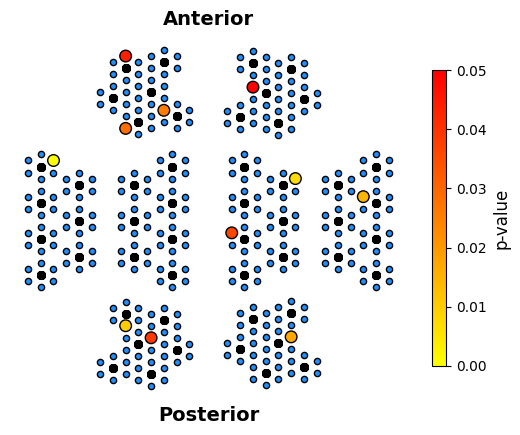

In [4]:
FR.plot_stat_results(exp_name, hemo_type, "2D")

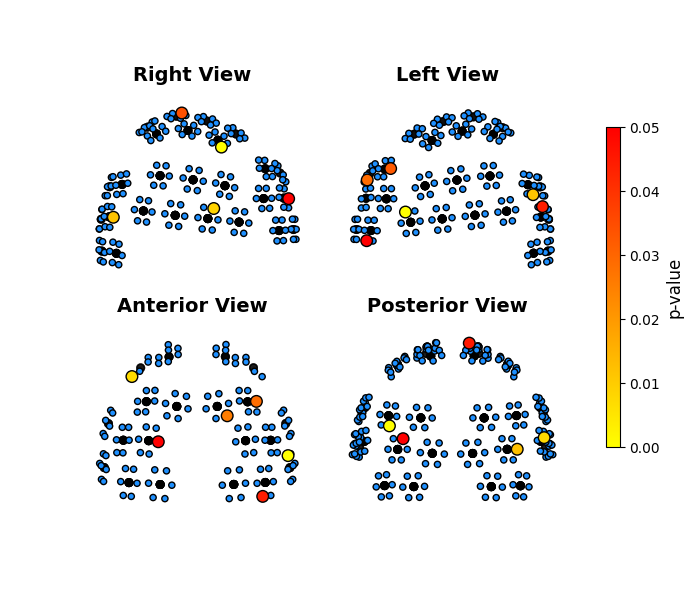

In [5]:
FR.plot_stat_results(exp_name, hemo_type, "3D")

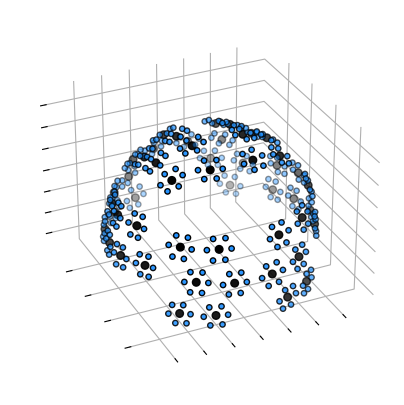

In [6]:
detector_pos_3d = par.flow_session_dict["session_1001"].get_detector_pos("3D")
x_detector = detector_pos_3d[:, 0]
y_detector = detector_pos_3d[:, 1]
z_detector = detector_pos_3d[:, 2]

source_pos_3d = par.flow_session_dict["session_1001"].get_source_pos("3D")
x_source = source_pos_3d[:, 0]
y_source = source_pos_3d[:, 1]
z_source = source_pos_3d[:, 2]

fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_detector, y_detector, z_detector, s=15, c="dodgerblue", edgecolors="black")
ax.scatter(x_source, y_source, z_source, s=30, c="black")

ax.patch.set_alpha(0.0)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis.line.set_color("none")  
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.line.set_color("none")  
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color("none") 
# ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])

ax.view_init(azim=245)
# ax.legend(["Detector", "Source"])
# plt.savefig(
    # os.path.join(r"C:\Users\zackg\OneDrive\Ayaz Lab\NEBEC\Submission\test_figs", f"all.png"), transparent=True, bbox_inches="tight"
# )
plt.show()

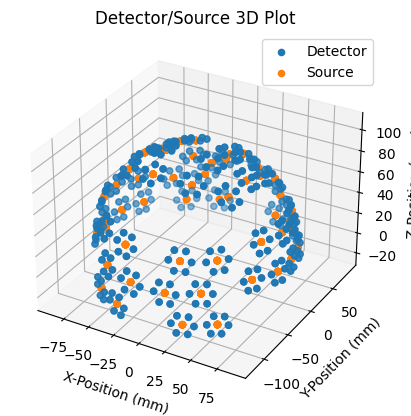

In [3]:
par.flow_session_dict["session_1001"].plot_pos("3d", add_missing=True)

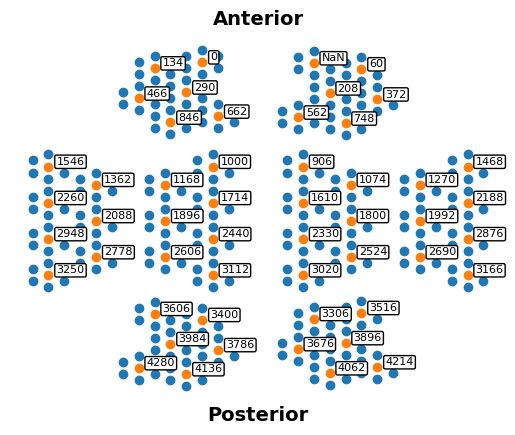

In [4]:
par.flow_session_dict["session_1001"].plot_pos("2d", add_labels=True, minimal=True)


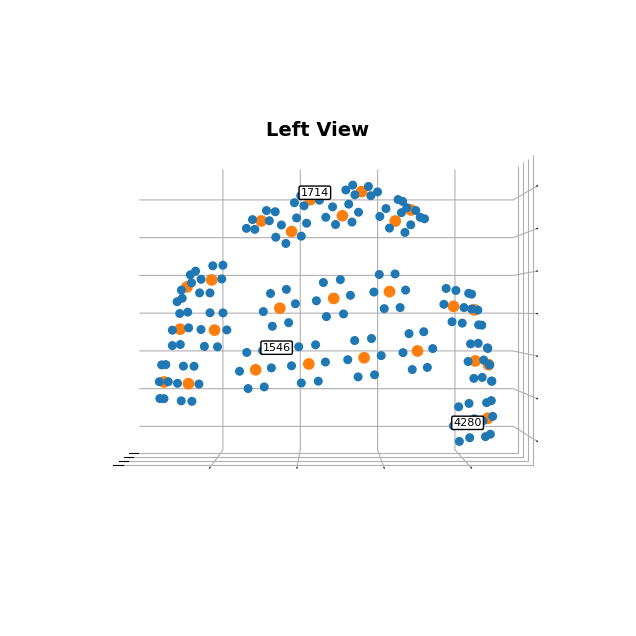

In [180]:
dim = "3D"
add_missing = True
# add_labels = True
add_labels = False
hemo_type = "HbO"
label_x_offset = 0.03
label_y_offset = 0.01
minimal = True
azim = 120
# view = None
# view = "anterior"
# view = "posterior"
view = "left"
# view = "right"
# highlight = None
highlight = [1714, 1546, 4280]


def _get_highlight_channels(plot_df: pd.DataFrame, highlight: list) -> pd.DataFrame:
    return plot_df[plot_df["channel_num"].isin(highlight)]


def _add_labels(
    plot_df: pd.DataFrame,
    dim: int,
    opt_type: str = "source",
    label_x_offset: int = 0,
    label_y_offset: int = 0,
    label_z_offset: int = 0,
):
    if dim.lower() == "2d":
        labels = plot_df["channel_num"]
        if opt_type == "source":
            x_pos = list(plot_df["source_x_pos"])
            y_pos = list(plot_df["source_y_pos"])
        elif opt_type == "detector":
            x_pos = list(plot_df["detector_x_pos"])
            y_pos = list(plot_df["detector_y_pos"])
        for i, label in enumerate(labels):
            try:
                ax.annotate(
                    label,
                    (x_pos[i], y_pos[i]),
                    xytext=(label_x_offset, label_y_offset),
                    textcoords="offset points",
                    fontsize=8,
                    ha="left",
                    va="center",
                    bbox=dict(
                        boxstyle="round,pad=0.15",
                        edgecolor="black",
                        facecolor="white",
                        alpha=1,
                    ),
                    arrowprops=dict(arrowstyle="->", facecolor="black", linewidth=2),
                )
            except TypeError:
                ax.annotate(
                    "NaN",
                    (x_pos[i], y_pos[i]),
                    xytext=(label_x_offset, label_y_offset),
                    textcoords="offset points",
                    fontsize=8,
                    ha="left",
                    va="center",
                    bbox=dict(
                        boxstyle="round,pad=0.15",
                        edgecolor="black",
                        facecolor="white",
                        alpha=1,
                    ),
                    arrowprops=dict(arrowstyle="->", facecolor="black", linewidth=2),
                )
    elif dim.lower() == "3d":
        labels = plot_df["channel_num"]
        if opt_type == "source":
            x_pos = list(plot_df["source_x_pos"])
            y_pos = list(plot_df["source_y_pos"])
            z_pos = list(plot_df["source_z_pos"])
        elif opt_type == "detector":
            x_pos = list(plot_df["detector_x_pos"])
            y_pos = list(plot_df["detector_y_pos"])
            z_pos = list(plot_df["detector_z_pos"])
        for i, label in enumerate(labels):
            try:
                ax.text(
                    x_pos[i] + label_x_offset,
                    y_pos[i] + label_y_offset,
                    z_pos[i] + label_z_offset,
                    label,
                    fontsize=8,
                    bbox=dict(
                        boxstyle="round,pad=0.15",
                        edgecolor="black",
                        facecolor="white",
                        alpha=1,
                    ),
                )
            except TypeError:
                ax.text(
                    x_pos[i] + label_x_offset,
                    y_pos[i] + label_y_offset,
                    z_pos[i] + label_z_offset,
                    "NaN",
                    fontsize=8,
                    bbox=dict(
                        boxstyle="round,pad=0.15",
                        edgecolor="black",
                        facecolor="white",
                        alpha=1,
                    ),
                )


source_detector_df = par.flow_session_dict["session_1001"].create_source_detector_df(
    dim, add_missing
)
source_detector_hemo = source_detector_df[
    source_detector_df["data_type_index"] == hemo_type
]
uni_source_label_df = source_detector_hemo.drop_duplicates(subset="source_index")

if dim.lower() == "2d":
    x_detector = list(source_detector_hemo["detector_x_pos"])
    y_detector = list(source_detector_hemo["detector_y_pos"])
    x_source = list(uni_source_label_df["source_x_pos"])
    y_source = list(uni_source_label_df["source_y_pos"])
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.scatter(x_detector, y_detector, s=40)
    ax.scatter(x_source, y_source, s=70)
    if add_labels and not highlight:
        label_x_offset = 0.03
        label_y_offset = 0.01
        _add_labels(uni_source_label_df, dim, "source", label_x_offset, label_y_offset)
    if minimal:
        ax.set_title("Anterior", fontweight="bold", fontsize=14)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.text(
            0.5,
            -0.06,
            "Posterior",
            fontweight="bold",
            fontsize=14,
            ha="center",
            va="bottom",
            transform=ax.transAxes,
        )
    else:
        ax.set_title("Detector/Source 2D Plot")
        ax.set_xlabel("X-Position (mm)")
        ax.set_ylabel("Y-Position (mm)")
        ax.legend(["Detector", "Source"])
    if highlight:
        label_x_offset = 12
        label_y_offset = 12
        highlight_rows = _get_highlight_channels(source_detector_hemo, highlight)
        _add_labels(highlight_rows, dim, "detector", label_x_offset, label_y_offset)

elif dim.lower() == "3d":
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d", computed_zorder=False)
    if not view:
        x_detector = list(source_detector_hemo["detector_x_pos"])
        y_detector = list(source_detector_hemo["detector_y_pos"])
        z_detector = list(source_detector_hemo["detector_z_pos"])
        x_source = list(uni_source_label_df["source_x_pos"])
        y_source = list(uni_source_label_df["source_y_pos"])
        z_source = list(uni_source_label_df["source_z_pos"])
        ax.scatter(x_detector, y_detector, z_detector, s=30)
        ax.scatter(x_source, y_source, z_source, s=55)
        ax.view_init(azim=azim)
        if add_labels and not highlight:
            _add_labels(uni_source_label_df, dim, "source")
        if highlight:
            label_x_offset = 0
            label_y_offset = 0
            label_z_offset = 0
            highlight_rows = _get_highlight_channels(source_detector_hemo, highlight)
            _add_labels(
                highlight_rows,
                dim,
                "detector",
                label_x_offset,
                label_y_offset,
                label_z_offset,
            )
    else:
        views = {
            "right": 0,
            "left": 180,
            "anterior": 90,
            "posterior": 270,
        }
        ax.view_init(elev=0, azim=views[view])
        if view == "right":
            source_plot_df = uni_source_label_df[
                uni_source_label_df["source_x_pos"] >= 0
            ]
            detector_plot_df = source_detector_hemo[
                source_detector_hemo["detector_x_pos"] >= 0
            ]
            ax.set_title("Right View", fontweight="bold", fontsize=14, y=0.85)
        elif view == "left":
            source_plot_df = uni_source_label_df[
                uni_source_label_df["source_x_pos"] <= 0
            ]
            detector_plot_df = source_detector_hemo[
                source_detector_hemo["detector_x_pos"] <= 0
            ]
            ax.set_title("Left View", fontweight="bold", fontsize=14, y=0.85)
        elif view == "anterior":
            source_plot_df = uni_source_label_df[
                uni_source_label_df["source_y_pos"] > 0
            ]
            detector_plot_df = source_detector_hemo[
                source_detector_hemo["detector_y_pos"] > 0
            ]
            ax.set_title("Anterior View", fontweight="bold", fontsize=14, y=0.85)
            x_off, y_off, z_off = -2, 0, 2
        elif view == "posterior":
            source_plot_df = uni_source_label_df[
                uni_source_label_df["source_y_pos"] <= 0
            ]
            detector_plot_df = source_detector_hemo[
                source_detector_hemo["detector_y_pos"] <= 0
            ]
            ax.set_title("Posterior View", fontweight="bold", fontsize=14, y=0.85)
            x_off, y_off, z_off = 2, 0, 2
        if add_labels and not highlight:
            try:
                _add_labels(source_plot_df, dim, "source", x_off, y_off, z_off)
            except NameError:
                _add_labels(source_plot_df, dim, "source")
        ax.scatter(
            detector_plot_df["detector_x_pos"],
            detector_plot_df["detector_y_pos"],
            detector_plot_df["detector_z_pos"],
            s=30,
            alpha=1,
            zorder=2,
        )
        ax.scatter(
            source_plot_df["source_x_pos"],
            source_plot_df["source_y_pos"],
            source_plot_df["source_z_pos"],
            s=55,
            alpha=1,
            zorder=1,
        )
        if highlight:
            label_x_offset = 0
            label_y_offset = 0
            label_z_offset = 0
            highlight_rows = _get_highlight_channels(detector_plot_df, highlight)
            _add_labels(
                highlight_rows,
                dim,
                "detector",
                label_x_offset,
                label_y_offset,
                label_z_offset,
            )

    if minimal:
        ax.patch.set_alpha(0.0)
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.xaxis.line.set_color("none")
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.line.set_color("none")
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.line.set_color("none")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    else:
        ax.set_title("Detector/Source 3D Plot")
        ax.set_xlabel("X-Position (mm)")
        ax.set_ylabel("Y-Position (mm)")
        ax.set_zlabel("Z-Position (mm)")
        ax.legend(["Detector", "Source"])


In [163]:
highlight_rows

,channel_num,measurement_list_index,data_type,data_type_index,detector_index,source_index,source_label,source_x_pos,source_y_pos,source_z_pos,detector_label,detector_x_pos,detector_y_pos,detector_z_pos
228,1546,1547,99999,HbO,109,19,S19,-77.493964,24.635807,12.929966,D19d0,-78.616060,20.526561,22.147313
252,1714,1715,99999,HbO,121,21,S21,-23.833963,-6.794071,98.524283,D21d0,-16.285727,-0.603432,101.096909
612,4280,4281,99999,HbO,301,51,S51,-56.993148,-99.328864,-13.652867,D51d0,-64.353876,-92.753542,-15.015656


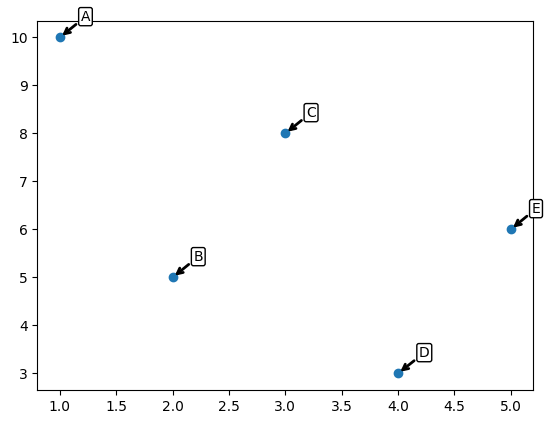

In [155]:
import matplotlib.pyplot as plt

# Create a sample scatter plot
x = [1, 2, 3, 4, 5]
y = [10, 5, 8, 3, 6]
labels = ['A', 'B', 'C', 'D', 'E']
fig, ax = plt.subplots()
ax.scatter(x, y)
for i, label in enumerate(labels):
    ax.annotate(label, (x[i], y[i]), xytext=(15, 15), textcoords='offset points',
                ha='left', va='center',
                arrowprops=dict(arrowstyle="->", facecolor='black', linewidth=2),
                bbox=dict(
                        boxstyle="round,pad=0.15",
                        edgecolor="black",
                        facecolor="white",
                        alpha=1,
                    ))

# Show the plot
plt.show()


ValueError: too many values to unpack (expected 2)

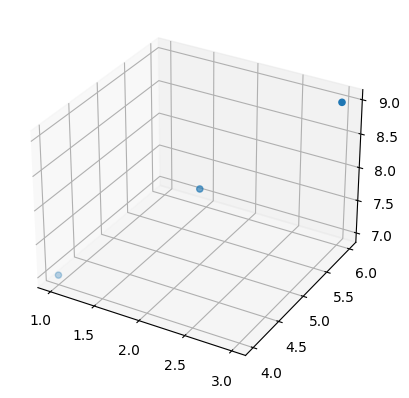

In [170]:
from mpl_toolkits.mplot3d.proj3d import proj_transform

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create 3D scatter plot
x = [1, 2, 3]
y = [4, 5, 6]
z = [7, 8, 9]
ax.scatter(x, y, z)

# Annotate a point with an arrow
label = "Point A"
x_i, y_i, z_i = 2, 5, 8

def annotate3D(ax, s, xyz, offset=(-20, 20), ha='center', va='center', bbox=None, arrowprops=None):
    x, y, z = xyz
    text = ax.text(x + offset[0], y + offset[1], z, s, ha=ha, va=va, bbox=bbox)
    if arrowprops:
        arrowprops = dict(connectionstyle="arc3,rad=-0.2", **arrowprops)
        angle = np.deg2rad(ax.azim)
        sin_angle, cos_angle = np.sin(angle), np.cos(angle)
        x_dir, y_dir, z_dir = cos_angle, -sin_angle, 0
        x_dir, y_dir, z_dir = proj_transform(x_dir, y_dir, z_dir, ax.get_proj())
        arrow_begin = (x + offset[0] / 2 * x_dir, y + offset[1] / 2 * y_dir, z)
        arrow_end = (x + offset[0] * x_dir, y + offset[1] * y_dir, z)
        arrow = ax.annotate('', arrow_end, arrow_begin, arrowprops=arrowprops, xycoords='data', textcoords='data')
    return text, arrow

annotate3D(ax, label, (x_i, y_i, z_i), arrowprops=dict(linewidth=2, arrowstyle='->', color='r', mutation_scale=10))

plt.show()
